<a href="https://colab.research.google.com/github/guthi1/technical-analysis-trading-dumpster-fire/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PolyFinances article

### TODO: Explain de situation

In [ ]:
# Install required librairy
!pip install yfinance

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import yfinance as yf

In [3]:
DEBUG = True
DATA_DIR = "data/"
DATA_CANDLE = "data/candle/"
DATA_NORMAL = "data/normal/"
!mkdir data
!mkdir data/candle
!mkdir data/normal
PRICE_INTERVAL = 2 # In minute, Must be in: 1m,2m,5m,15m,30m,60m,90m
WINDOWS_INTERVAL = 60 # In minute, must be > than PRICE_INTERVAL
assert WINDOWS_INTERVAL > PRICE_INTERVAL, "window for analysis must be greater than the price interval"

HOLD = 0
BUY = 1
SELL = 2

## Create Dataset

In [4]:
# Download the data
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "SPY AAPL MSFT TSLA GE F AMZN AQN TD",
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "5d",
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        interval = f"{PRICE_INTERVAL}m",
        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',
        # attempt repair of missing data or currency mixups e.g. $/cents
        repair = True,
        # use threads for mass downloading
        threads = True
    )

print(f"Number of row: {len(data)}")
data.head()

[*********************100%***********************]  9 of 9 completed
Number of row: 976


AQN                                                F  \
                      Open    High     Low  Close Adj Close  Volume    Open   
Datetime                                                                      
2023-01-09 09:30:00  7.270  7.3200  7.2700  7.275     7.275  175230  12.740   
2023-01-09 09:32:00  7.275  7.2750  7.2307  7.240     7.240   27923  12.720   
2023-01-09 09:34:00  7.240  7.2422  7.2000  7.215     7.215   55662  12.650   
2023-01-09 09:36:00  7.220  7.2400  7.2100  7.225     7.225  110361  12.690   
2023-01-09 09:38:00  7.230  7.2400  7.2100  7.230     7.230   69507  12.625   

                                            ...       AMZN             \
                      High    Low    Close  ...        Low      Close   
Datetime                                    ...                         
2023-01-09 09:30:00  12.76  12.67  12.7101  ...  87.459999  88.410004   
2023-01-09 09:32:00  12.73  12.65  12.6515  ...  88.150101  88.500000   
2023-01-09 09:34:00  12.70  12.64  12.6850  ...  88.290001  88.470001   
2023-01-09 09:36:00  12.70  12.62  12.6200  ...  87.909897  88.157303   
2023-01-09 09:38:00  12.66  12.58  12.5950  ...  88.120003  88.394997   

                                                SPY                          \
                     Adj Close   Volume        Open        High         Low   
Datetime                                                                      
2023-01-09 09:30:00  88.410004  3916487  390.369995  390.450012  389.839996   
2023-01-09 09:32:00  88.500000  1074282  390.440002  390.839996  390.130005   
2023-01-09 09:34:00  88.470001   712346  390.160004  390.309998  389.709991   
2023-01-09 09:36:00  88.157303   985453  389.829987  389.959991  389.420013   
2023-01-09 09:38:00  88.394997   708215  389.630005  389.920105  389.350006   

                                                      
                          Close   Adj Close   Volume  
Datetime                                              
2023-01-09 09:30:00  390.410004  390.410004  2402676  
2023-01-09 09:32:00  390.170013  390.170013   487845  
2023-01-09 09:34:00  389.825012  389.825012   501256  
2023-01-09 09:36:00  389.639709  389.639709   451951  
2023-01-09 09:38:00  389.880005  389.880005   367161  

[5 rows x 54 columns]

Build dataset

In [5]:
plot_number = 0
# Dataframe to save the value we need
dataset={"candle_path": [], "normal_path": [], "action": [], "info": [], "filename": []}

In [6]:
# Let's try it for ford first
ticker = "F"
ticker_data = data[ticker]
ticker_data.dropna() # Sanity check
ticker_data["datetime"] = ticker_data.index

# Find Dataset range
day = ticker_data['datetime'].min()
last_end = ticker_data['datetime'].max()
if DEBUG: print(f"From {day} to {last_end}")

plt.close()

while day <= last_end:
    if DEBUG: print(f"{day}")

    start_window = day
    end_window = start_window + datetime.timedelta(minutes=WINDOWS_INTERVAL)
    end_of_day = day + datetime.timedelta(hours=6.5)

    while start_window < end_of_day - datetime.timedelta(minutes=WINDOWS_INTERVAL):
        if DEBUG: print(f"    {start_window}")

        # Create a mask for the desired window
        mask = (ticker_data['datetime'] > start_window) & (ticker_data['datetime'] <= end_window)
        window_data = ticker_data.loc[mask]
        """ TODO: This could be change to something smarter """
        mean_close = window_data.Close.mean()

        # "up" dataframe will store the stock_prices when the closing stock 
        # price is greater than or equal to the opening stock prices
        up = window_data[window_data.Close >= window_data.Open]
        col1 = 'red'

        # "down" dataframe will store the stock_prices when the closing stock 
        # price is lesser than the opening stock prices
        down = window_data[window_data.Close < window_data.Open]
        col2 = 'blue'

        # Setting width of candlestick elements
        width = .0005
        width2 = .00008

        # Plotting up prices of the stock
        plt.bar(up.datetime, up.Close-up.Open, width, bottom=up.Open, color=col1)
        plt.bar(up.datetime, up.High-up.Close, width2, bottom=up.Close, color=col1)
        plt.bar(up.datetime, up.Low-up.Open, width2, bottom=up.Open, color=col1)

        # Plotting down prices of the stock
        plt.bar(down.datetime, down.Close-down.Open, width, bottom=down.Open, color=col2)
        plt.bar(down.datetime, down.High-down.Open, width2, bottom=down.Open, color=col2)
        plt.bar(down.datetime, down.Low-down.Close, width2, bottom=down.Close, color=col2)
        plt.axis('off')

        # Saving the candle plot
        plt_name = f"{plot_number}.png"
        plt.savefig(f"{DATA_CANDLE}{plt_name}", format="png")
        plt.close()    
        dataset["filename"].append(plt_name)
        dataset["candle_path"].append(DATA_CANDLE)

        # Plotting the time series of given dataframe
        plt.plot(window_data["datetime"], window_data["Adj Close"])
        plt.axis('off')

        # Saving the normal plot
        plt_name = f"{DATA_NORMAL}{plot_number}.png"
        plt.savefig(plt_name, format="png")
        plt.close()    
        dataset["normal_path"].append(DATA_CANDLE)
        
        # Update var
        plot_number += 1
        start_window = end_window
        end_window = start_window + datetime.timedelta(minutes=WINDOWS_INTERVAL)

        # Check if it's a hold, buy and sold
        """ TODO: This could be change to something smarter """
        mask = (ticker_data['datetime'] > start_window) & (ticker_data['datetime'] <= end_window)
        window_data = ticker_data.loc[mask]
        mean_close_next_interval = window_data.Close.mean()

        diff = mean_close_next_interval / mean_close
        if diff > 1.002:
            dataset["action"].append(BUY)
        elif diff < 0.998:
            dataset["action"].append(SELL)
        else:
            dataset["action"].append(HOLD)

        # For debugging later
        dataset["info"].append(f"{ticker}: {start_window}")

    day += datetime.timedelta(days=1)

<ipython-input-6-c69a98fb9b34>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data["datetime"] = ticker_data.index


From 2023-01-09 09:30:00 to 2023-01-13 16:00:00
2023-01-09 09:30:00
    2023-01-09 09:30:00
    2023-01-09 10:30:00
    2023-01-09 11:30:00
    2023-01-09 12:30:00
    2023-01-09 13:30:00
    2023-01-09 14:30:00
2023-01-10 09:30:00
    2023-01-10 09:30:00
    2023-01-10 10:30:00
    2023-01-10 11:30:00
    2023-01-10 12:30:00
    2023-01-10 13:30:00
    2023-01-10 14:30:00
2023-01-11 09:30:00
    2023-01-11 09:30:00
    2023-01-11 10:30:00
    2023-01-11 11:30:00
    2023-01-11 12:30:00
    2023-01-11 13:30:00
    2023-01-11 14:30:00
2023-01-12 09:30:00
    2023-01-12 09:30:00
    2023-01-12 10:30:00
    2023-01-12 11:30:00
    2023-01-12 12:30:00
    2023-01-12 13:30:00
    2023-01-12 14:30:00
2023-01-13 09:30:00
    2023-01-13 09:30:00
    2023-01-13 10:30:00
    2023-01-13 11:30:00
    2023-01-13 12:30:00
    2023-01-13 13:30:00
    2023-01-13 14:30:00


In [7]:
dataset = pd.DataFrame(data=dataset)
dataset.head()

,candle_path,normal_path,action,info,filename
0,data/candle/,data/candle/,1,F: 2023-01-09 10:30:00,0.png
1,data/candle/,data/candle/,1,F: 2023-01-09 11:30:00,1.png
2,data/candle/,data/candle/,2,F: 2023-01-09 12:30:00,2.png
3,data/candle/,data/candle/,0,F: 2023-01-09 13:30:00,3.png
4,data/candle/,data/candle/,2,F: 2023-01-09 14:30:00,4.png


## DataLoader

In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
device = "cuda" if torch.cuda.is_available() else "cpu"

# Fix random seed
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Let's create a data loader for the dataset we created

In [61]:
class TechnicalAnalysisDataset(torch.utils.data.Dataset):
    def __init__(self, data, chart_dir, transform=None):
        self.df = data
        self.img_dir = chart_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]["filename"])
        image = read_image(img_path)
        image = image / 255
        label = self.df.iloc[idx]["action"]
        if self.transform:
            image = self.transform(image)
        return image, label

Now that we have our dataset, we will need to split it in a training and validation set and we will need a data loader to be able to have minibatch.

In [62]:
def train_test_split(df, frac=0.2):
    
    # get random sample 
    test = df.sample(frac=frac, axis=0)

    # get everything but the test sample
    train = df.drop(index=test.index)

    return train, test

In [63]:
from torch.utils.data import DataLoader

train_dataset, test_dataset = train_test_split(dataset)

train_technical_analysis_dataset = TechnicalAnalysisDataset(train_dataset, DATA_CANDLE, transform=resize_transform)
test_technical_analysis_dataset = TechnicalAnalysisDataset(test_dataset, DATA_CANDLE, transform=resize_transform)

train_loader = torch.utils.data.DataLoader(
    train_technical_analysis_dataset, batch_size=128, shuffle=True, num_workers=2
)

val_loader = torch.utils.data.DataLoader(
      test_technical_analysis_dataset, batch_size=128, shuffle=False, num_workers=2
)

torch.Size([256, 256, 4])
2


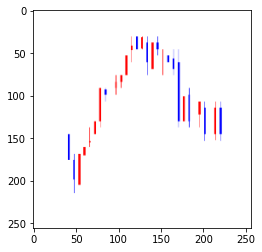

In [64]:
# Sanity check
img, label = train_technical_analysis_dataset.__getitem__(1)
img = img.permute(1, 2, 0)
print(img.shape)
print(label)
plt.imshow(img)
plt.show()

## Training architecture

In [65]:
def train_loop(epoch, model, train_loader, criterion, optimizer):
  """
    epoch: int
      Number of the current training epoch (starting from 0).
    model: ResNet18
      The model to train, which is an instance of the ResNet18 class.
    train_loader: DataLoader
      The training dataloader.
    criterion: Module
      A Module object that evaluates the crossentropy loss.
    optimizer: Optimizer
      An Optimizer object for the Adam optimizer.

    Outputs: Returns average train_acc and train_loss for the current epoch.
  """
  train_acc = 0.
  train_loss = 0.
  nb_data = 0 
  model.train()
  for inputs, labels in train_loader:
      # Get input:
      inputs, labels = inputs.to(device), labels.to(device)

      # Zeros the parameter gradient
      optimizer.zero_grad()
      
      # Foward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Get stats
      train_loss += loss.item()
      _, pred = torch.max(outputs.data, 1)
      train_acc += (pred == labels).sum().item()
      nb_data += labels.size(0)

  train_loss = train_loss / len(train_loader)
  train_acc = train_acc / nb_data

  print(f"Epoch: {epoch} | Train Acc: {train_acc:.6f} | Train Loss: {train_loss:.6f}")
  return train_acc, train_loss

def valid_loop(epoch, model, val_loader, criterion):
  """
    epoch: int
      Number of the current epoch (starting from 0).
    model: ResNet18
      The model to train, which is an instance of the ResNet18 class.
    val_loader: DataLoader
      The validation dataloader.
    criterion: Module
      A Module object that evaluates the crossentropy loss.

    Outputs: Returns average val_acc and val_loss for the current epoch.
  """
  val_acc = 0.
  val_loss = 0.
  nb_data = 0

  model.eval()
  for inputs, labels in val_loader:
      # Get input:
      inputs, labels = inputs.to(device), labels.to(device)
      
      # Foward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      # Get stats
      val_loss += loss.item()
      _, pred = torch.max(outputs.data, 1)
      val_acc += (pred == labels).sum().item()
      nb_data += labels.size(0)

  val_loss = val_loss / len(val_loader)
  val_acc = val_acc / nb_data

  print(f"Epoch: {epoch} | Val Acc: {val_acc:.6f}   | Val Loss: {val_loss:.6f}")
  return val_acc, val_loss

## Models



### MLP

In [66]:
from torch.nn.modules.dropout import Dropout
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4*256*256, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(512, 254),
            nn.ReLU(),
            nn.Dropout(p=0.05),
            nn.Linear(254, 3)
        )
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        out = self.model(x)
        return out

In [ ]:
import time
if __name__ == "__main__":
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")

  train_accs, train_losses, val_accs, val_losses = [], [], [], []
  n_epochs = 12

  mlp = MLP().to(device)
  nb_params = sum(p.numel() for p in mlp.parameters())
  print(mlp)
  print(f"Number of parameter: {nb_params}")

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(mlp.parameters())

  tic = time.perf_counter()
  for epoch in range(n_epochs):
    # Training
    train_acc, train_loss = train_loop(epoch, mlp, train_loader, criterion, optimizer)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    val_acc, val_loss = valid_loop(epoch, mlp, val_loader, criterion)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

  toc = time.perf_counter()
  print(f"Time to train {toc - tic:0.4f} seconds")

### Resnet-18

After that, we can try with Resnet-18. This might be overkill, but why not, I won't trade any real money in the end

In [14]:
class ResidualBlock(nn.Module):
  """This class implements the Residual Block used in ResNet-18."""

  def __init__(self, in_channels, channels, conv_stride=1, activation_str="relu", initialization="xavier_normal"):
    """
      Constructor for the ResidualBlock class.

      in_channels: int
        Number of channels in the input to the block.
      channels: int
        Number of output channels for the block, i.e., number of filters.
      conv_stride: int, default 1
        Stride of the first convolution layer and downsampling convolution (if required).
      activation_str: string, default "relu"
        Activation function to use.
      initialization: string, default "xavier_normal"
        Initialization for convolution layer weights.
    """
    super(ResidualBlock, self).__init__()

    self.in_channels = in_channels
    self.channels = channels
    self.conv_stride = conv_stride
    self.activation_str = activation_str
    self.initialization = initialization

    # Define these members by replacing `None` with the correct definitions
    self.conv1 = nn.Conv2d(in_channels, channels, 3, stride=conv_stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(channels)
    self.conv2 = nn.Conv2d(channels, channels, 3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(channels)

    self.residual_connection = self.residual(in_channels, channels, conv_stride)

    # Initialize weights for conv1 and conv2
    if initialization == "xavier_normal":
      nn.init.xavier_normal_(self.conv1.weight)
      nn.init.xavier_normal_(self.conv2.weight)
    elif initialization == "xavier_uniform": 
      nn.init.xavier_uniform_(self.conv1.weight)
      nn.init.xavier_uniform_(self.conv2.weight)
    elif initialization == "kaiming_normal": 
      nn.init.kaiming_normal_(self.conv1.weight)
      nn.init.kaiming_normal_(self.conv2.weight)
    else:
      raise Exception("Invalid initialization")

  def activation(self, input):
    """
      input: Tensor
        Input on which the activation is applied.

      Output: Result of activation function applied on input.
        E.g. if self.activation_str is "relu", return relu(input).
    """
    if self.activation_str == "relu":
      return torch.relu(input)
    elif self.activation_str == "tanh":
      return torch.tanh(input)
    else:
      raise Exception("Invalid activation")

  def residual(self, in_channels, channels, conv_stride=1):
    """
      in_channels: int
        Number of input channels in the input to the block.
      channels: int
        Number of output channels for the block, i.e., number of filters.
      conv_stride: int, default 1
        Stride to use for downsampling 1x1 convolution.

      Output: Returns an nn.Sequential object which computes the identity function of the input if stride is 1
              and the number of input channels equals the number of output channels. Otherwise, it returns an
              nn.Sequential object that downsamples its input using a 1x1-conv of the stride specified and
              followed by a BatchNorm2d.
    """
    layers = []
    if conv_stride != 1 or in_channels != channels:
      layers.append(nn.Conv2d(in_channels, channels, 1, stride=conv_stride, padding=0, bias=False))
      layers.append(nn.BatchNorm2d(channels))
    return nn.Sequential(*layers)

  def forward(self, x):
    """
      x: Tensor
        Input to the block.

      Outputs: Returns the output of the forward pass of the block.
    """
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.activation(out)

    out = self.conv2(out)
    out = self.bn2(out)

    out += self.residual_connection(identity)
    out = self.activation(out)

    return out

We can than create the model

In [15]:
class ResNet18(nn.Module):
  """This class implements the ResNet-18 architecture from its components."""

  def __init__(self, activation_str="relu", initialization="xavier_normal"):
    """
      Constructor for the ResNet18 class.

      activation_str: string, default "relu"
        Activation function to use.
      initialization: string, default "xavier_normal"
        Weight initialization to use.
    """
    super(ResNet18, self).__init__()

    self.n_classes = 10
    self.activation_str = activation_str
    self.initialization = initialization

    self.conv1 = nn.Conv2d(4, 64, 3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._create_layer(64, 64) 
    self.layer2 = self._create_layer(64, 128, conv_stride=2)
    self.layer3 = self._create_layer(128, 256, conv_stride=2)
    self.layer4 = self._create_layer(256, 512, conv_stride=2)  
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.linear = nn.Linear(512, 3)
  
  def activation(self, input):
    """
      input: Tensor
        Input on which the activation is applied.

      Output: Result of activation function applied on input.
        E.g. if self.activation_str is "relu", return relu(input).
    """
    if self.activation_str == "relu":
      return torch.relu(input)
    elif self.activation_str == "tanh":
      return torch.tanh(input)
    else:
      raise Exception("Invalid activation")

  def _create_layer(self, in_channels, channels, conv_stride=1):
    """
      in_channels: int
        Number of input channels present in the input to the layer.
      out_channels: int
        Number of output channels for the layer, i.e., the number of filters.
      conv_stride: int, default 1
        Stride of the first convolution layer in the block and the downsampling convolution (if required).

      Outputs: Returns an nn.Sequential object giving a "layer" of the ResNet, consisting of 2 blocks each.
    """
    return nn.Sequential(
        ResidualBlock(in_channels, channels, conv_stride=conv_stride, activation_str=self.activation_str, initialization=self.initialization),
        ResidualBlock(channels, channels, conv_stride=1, activation_str=self.activation_str, initialization=self.initialization)
    )

  def get_first_conv_layer_filters(self):
    """
      Outputs: Returns the filters in the first convolution layer.
    """
    return self.conv1.weight.clone().cpu().detach().numpy()

  def get_last_conv_layer_filters(self):
    """
      Outputs: Returns the filters in the last convolution layer.
    """
    return list(self.layer4.modules())[1].conv2.weight.clone().cpu().detach().numpy()

  def forward(self, x):
    """
      x: Tensor
        Input to the network.

      Outputs: Returns the output of the forward pass of the network.
    """
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.activation(out)

    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    
    out = self.avgpool(out)
    out = torch.flatten(out, 1)
    out = self.linear(out)

    return out

In [16]:
# Parameter we will use
activation_str = "relu"
initialization = "xavier_normal"

In [18]:
# Training
if __name__ == "__main__":
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")

  train_accs, train_losses, val_accs, val_losses = [], [], [], []
  n_epochs = 25

  model = ResNet18(
    activation_str=activation_str,
    initialization=initialization
  ).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters())
  
  for epoch in range(n_epochs):
    # Training
    train_acc, train_loss = train_loop(epoch, model, train_loader, criterion, optimizer)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation
    val_acc, val_loss = valid_loop(epoch, model, val_loader, criterion)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
     

Epoch: 0 | Train Acc: 0.375000 | Train Loss: 2.266934
Epoch: 0 | Val Acc: 0.500000   | Val Loss: 2.936660
Epoch: 1 | Train Acc: 0.458333 | Train Loss: 1.434008
Epoch: 1 | Val Acc: 0.500000   | Val Loss: 3.821058
Epoch: 2 | Train Acc: 0.583333 | Train Loss: 1.031421
Epoch: 2 | Val Acc: 0.500000   | Val Loss: 1.956096
Epoch: 3 | Train Acc: 0.583333 | Train Loss: 0.872833
Epoch: 3 | Val Acc: 0.166667   | Val Loss: 1.847805
Epoch: 4 | Train Acc: 0.666667 | Train Loss: 0.705132
Epoch: 4 | Val Acc: 0.333333   | Val Loss: 1.559400
Epoch: 5 | Train Acc: 0.791667 | Train Loss: 0.572029
Epoch: 5 | Val Acc: 0.333333   | Val Loss: 1.330200
Epoch: 6 | Train Acc: 0.833333 | Train Loss: 0.446711
Epoch: 6 | Val Acc: 0.500000   | Val Loss: 1.427253
Epoch: 7 | Train Acc: 1.000000 | Train Loss: 0.332901
Epoch: 7 | Val Acc: 0.500000   | Val Loss: 1.809139
Epoch: 8 | Train Acc: 1.000000 | Train Loss: 0.233001
Epoch: 8 | Val Acc: 0.500000   | Val Loss: 1.962750
Epoch: 9 | Train Acc: 1.000000 | Train Loss: 0

In [ ]:
if __name__ == "__main__":
    torch.save(model, "resnet18")

In [ ]:
if __name__ == "__main__":
    model = torch.load("resnet18")

Let's see if the model learn something

We can finaly look how the model extract this information by looking at the learned filter

First layer

First layer filters


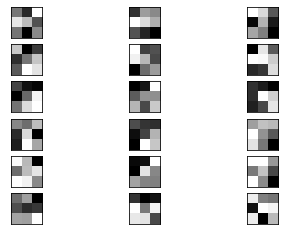

In [22]:
def print_filter(filters, n_filter_to_display=6):
    # Normalize 
    f_min, f_max = filters.max(), filters.min()
    filters = (filters - f_min) / (f_max - f_min)

    i_idx = 1
    for f_idx in range(n_filter_to_display):
        filter = filters[f_idx, :, :, :]
        for p_idx in range(3):
            ax = plt.subplot(n_filter_to_display, 3, i_idx)
            ax.set_xticks([])
            ax.set_yticks([])
            # Plot
            plt.imshow(filter[p_idx,:,:], cmap='gray')
            i_idx += 1
    plt.show()
    
if __name__ == "__main__":
    print("First layer filters")
    first_filters = model.get_first_conv_layer_filters()
    print_filter(first_filters)

Last layer filters


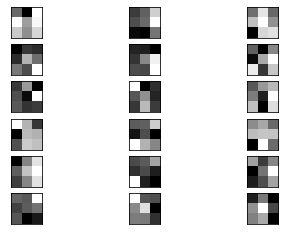

In [23]:
if __name__ == "__main__":
    print("Last layer filters")
    last_filters = model.get_last_conv_layer_filters()
    print_filter(last_filters)

Let see what the graph look like with those filter

In [ ]:
if __name__ == "__main__":

    # Fin output size
    img, label = train_technical_analysis_dataset.__getitem__(0)
    # vis_image = img.permute(1, 2, 0)
    vis_image = img
    channel, dim_x_img, dim_y_img = vis_image.shape
    dim_out = (dim_x_img-3)//1 + 1

    output = np.zeros((64, dim_out, dim_out))

    for filter_idx in range(first_filters.shape[0]):
        filter = first_filters[filter_idx]

        for channel_i in range(filter.shape[0]):
            # Apply kernel
            kernel = filter[channel_i]
            img = vis_image[channel_i].numpy()
            for i in range(0, dim_out):
                for j in range(0, dim_out):
                    # Select part of the img
                    img_patch = img[i:i+3, j:j+3]
                    # Apply kernel
                    kernel_output = np.multiply(img_patch, kernel)
                    kernel_output = np.sum(kernel_output)
                    # Save output
                    output[filter_idx, i, j] = kernel_output

    from matplotlib.pyplot import figure
    figure(figsize=(10,10))

    ax = [plt.subplot(8,8,i+1) for i in range(64)]

    for i, a in enumerate(ax):
        a.set_xticks([])
        a.set_yticks([])

        a.imshow(output[i,:,:], cmap='gray')

    plt.subplots_adjust(wspace=0., hspace=0.1)


Last layer

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor

if __name__ == "__main__":

    model_extract_last_features = create_feature_extractor(model, {"layer4": "layer4"})
    out = model_extract_last_features(vis_image.to(device))
    out['layer4'].shape

    figure(figsize=(10,10))

    ax = [plt.subplot(8,8,i+1) for i in range(64)]

    for i, a in enumerate(ax):
        a.set_xticks([])
        a.set_yticks([])

        image = out['layer4'].cpu().detach().numpy()[0, i,:,:]
        a.imshow(image, cmap='gray')

    plt.subplots_adjust(wspace=0., hspace=0.1)

### ViT

## Let's trade some stock and loose money, but in style hehe